# Import Librairies

In [501]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.spatial.distance import cdist

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering


# I- Explore and Transform Data

## A- Load Data Set 

In [502]:
companiesDataframe = pd.read_csv("KickstarterProject.csv", delimiter =",", encoding = "ISO-8859-1")

In [503]:
companiesDataframe.head()

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15      US        100.0   
2  2013-01-12 00:20:50    220.0    failed        3      US        220.0   
3  2012-03-17 03:24:11      1.0    failed        1      US          1.0   
4  2015-07-04 08:35:03   1283.0  canceled       14      US       1283.0   

   usd_pledged_real  usd_goal_real  
0               0.0        1533.95  
1            2421.0       30000.00  
2             220.0       45000.00  
3               1.0        5000.00  
4            1283.0       19500.00

## B- Check for missing values

In [506]:
companiesDataframe.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

Less of 1% of the observations contain missing values. We drop the rows with missing values.

In [505]:
companiesDataframe.dropna(inplace = True)

## C- Create Features

### Date related features:

Convert date type drom str to datetime:

In [507]:
companiesDataframe['dateOfLaunch'] = pd.to_datetime(companiesDataframe['launched'])
companiesDataframe = companiesDataframe.drop("launched",axis=1)

In [508]:
companiesDataframe['dateOfDeadline'] = pd.to_datetime(companiesDataframe['deadline'])
companiesDataframe = companiesDataframe.drop("deadline",axis=1)

Extract the year and the month from the date:

In [519]:
companiesDataframe['year'] = companiesDataframe['dateOfLaunch'].dt.year
companiesDataframe['month'] = companiesDataframe['dateOfLaunch'].dt.month
companiesDataframe['dayOfTheWeek'] = companiesDataframe['dateOfLaunch'].dt.weekday_name

Create'lengthOfCampain' feature which corresponds to the interval of time between launching date and the deadline date.



In [510]:
companiesDataframe['lengthOfCampain'] = companiesDataframe['dateOfDeadline'].sub(companiesDataframe['dateOfLaunch'], axis=0)
companiesDataframe['lengthOfCampain'] = companiesDataframe['lengthOfCampain'].dt.days

### Category related features:

Create three features that specify the average amount pledge, the average amount goal and the average number of backers per category.

In [511]:
companiesDataframe["averagePledgePerCategory"]=round(pd.DataFrame(companiesDataframe.groupby(['main_category'])['usd_pledged_real'].transform(lambda x: x.mean())))
companiesDataframe["averageGoalPerCategory"]=round(pd.DataFrame(companiesDataframe.groupby(['main_category'])['usd_goal_real'].transform(lambda x: x.mean())))
companiesDataframe["averageNumberofBackersPerCategory"]=round(pd.DataFrame(companiesDataframe.groupby(['main_category'])['backers'].transform(lambda x: x.mean())))

### Amount related features: 

Create a feature that stores the difference between the company goal amount and the goal amount average of its category.

In [517]:
companiesDataframe['differenceAmountBetweenCompanyGoalAndAverageGoal'] = companiesDataframe['usd_goal_real'] - companiesDataframe['averageGoalPerCategory']


Create a feature that specifies whether the company has raised more money than the average of its category or not. 

In [518]:
companiesDataframe['isAboveAverage'] = np.where(companiesDataframe['differenceAmountBetweenCompanyGoalAndAverageGoal'].apply(lambda x : x > 0), 1, 0 )

### Name of the company related features:

Get the lengh of a project name by counting the number of letters and the number of words

In [522]:
companiesDataframe['nameNumberLetters'] = companiesDataframe['name'].str.len()
companiesDataframe['numberOfWords'] = companiesDataframe['name'].str.strip().str.split('[\W_]+')
companiesDataframe['numberOfWords'] = companiesDataframe['numberOfWords'].str.len()

Check whether a project has exclaim marks, or question marks or if it is upper.

In [521]:
companiesDataframe['isExclaimInName'] = np.where(companiesDataframe.name.str[-1] == '!', 1, 0)
companiesDataframe['isQuestionInName'] = np.where(companiesDataframe.name.str[-1] == '?', 1, 0)
companiesDataframe['nameIsUpper'] = companiesDataframe.name.str.isupper().astype(float)

# II- Clustering Study

## A- Choose the data for training  

Let's focuse on projects emanating in 2017.

In [523]:
yearInterval=[2017,2017]
companiesDataframe = companiesDataframe[companiesDataframe.year.isin(yearInterval)]

Let's focuse on quantitative data.

In [526]:
companiesDataframeWithQuantitativeFeatures = companiesDataframe[['usd_pledged_real', 'usd_goal_real', 'backers', 
                                                                'month', 'lengthOfCampain', 'averagePledgePerCategory',
                                                                'averageGoalPerCategory', 'averageNumberofBackersPerCategory',
                                                                'differenceAmountBetweenCompanyGoalAndAverageGoal', 'isAboveAverage',
                                                                'nameNumberLetters', 'numberOfWords', 'isQuestionInName',
                                                                'isExclaimInName']]

Remove outliers.

In [527]:
def removeOutliers(dataframe, threshold):
    """Input: dataframe with numerical values
       Output: dataframe without outliers"""
    z = np.abs(stats.zscore(dataframe))

    return dataframe[(z <= threshold).all(axis=1)]

In [528]:
companiesDataframeWithQuantitativeFeaturesNoOutliers = removeOutliers(companiesDataframeWithQuantitativeFeatures, 3)

Remove Correlated Features with the correlation Heat Map

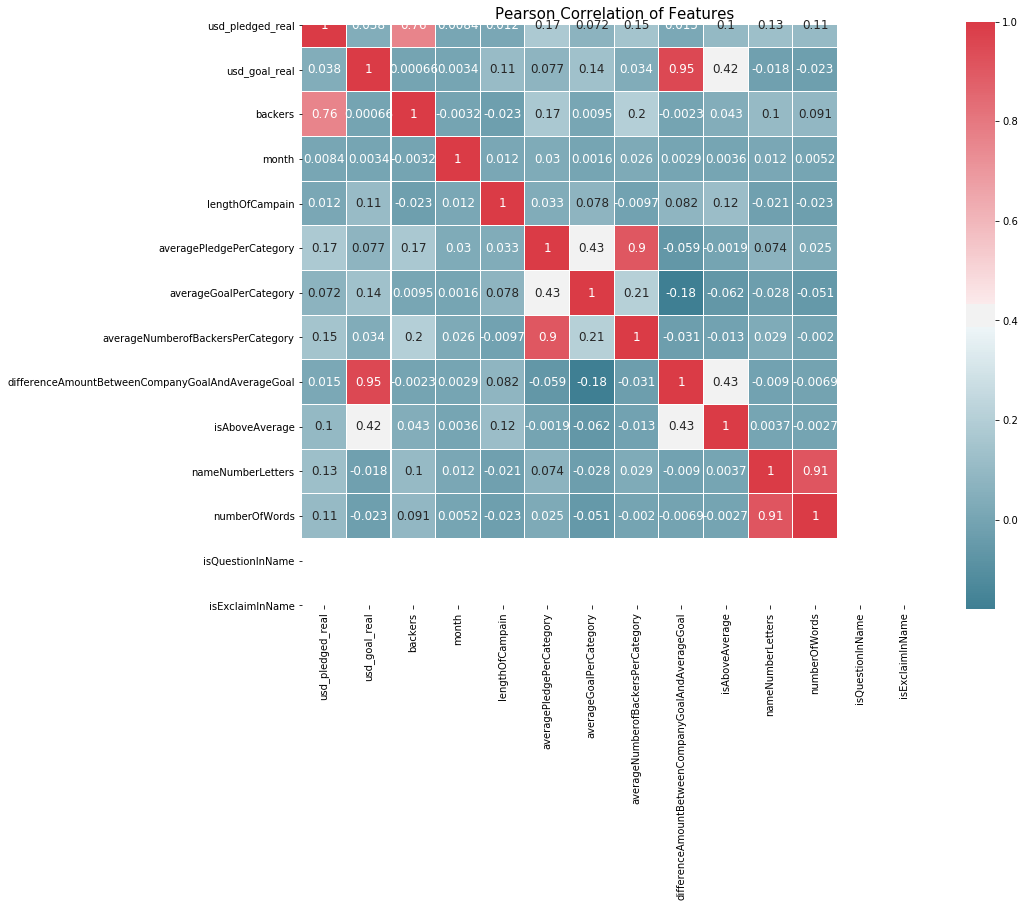

In [529]:
def correlation_heatmap(dataframe):
    """Input: dataframe with numerical values
       Ouput: Plot of correlation Matrix"""
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        dataframe.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    return plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(companiesDataframeWithQuantitativeFeaturesNoOutliers)
plt.show()

In [530]:
companiesDataframeForTraining = companiesDataframeWithQuantitativeFeaturesNoOutliers.drop(['differenceAmountBetweenCompanyGoalAndAverageGoal',
                                                                                           'averagePledgePerCategory', 'backers', 'numberOfWords',
                                                                                           'isQuestionInName', 'isExclaimInName'], axis=1)

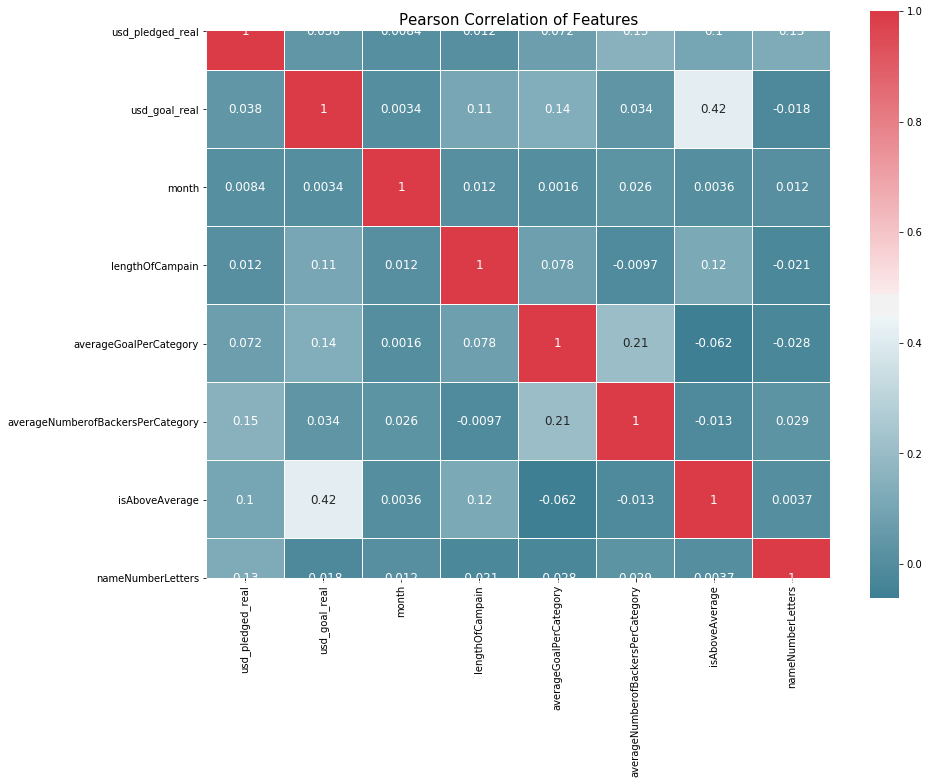

In [531]:
correlation_heatmap(companiesDataframeForTraining)
plt.show()

### Scale data

In [532]:
companiesDataframeForTrainingScaled = preprocessing.scale(companiesDataframeForTraining)

### Eigen Values

In [533]:
def getExplainedVariancePlot(dataframe):
    """
    Input : dataframe of pandas type
    Output : explained variance plot 
    """
    meanVector = np.mean(dataframe, axis=0)
    covarianceMatrix = np.cov(dataframe.T)
    
    eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)
    
    eigenPairs = [(np.abs(eigenValues[i]),eigenVectors[:,i]) for i in range(len(eigenValues))]
    eigenPairs.sort(key = lambda x: x[0], reverse= True)
    
    totalEigenValues = sum(eigenValues)
    varianceExplained = [(i/totalEigenValues)*100 for i in sorted(eigenValues, reverse=True)] # Individual explained variance
    cumulativeExplainedVariance = np.cumsum(varianceExplained)
    
    return plt.figure(figsize=(10, 5)), plt.bar(range(len(varianceExplained)), varianceExplained, alpha=0.3333, align='center', label='individual explained variance', color = 'g'), plt.step(range(len(cumulativeExplainedVariance)), cumulativeExplainedVariance, where='mid',label='cumulative explained variance'), plt.ylabel('Explained variance ratio'), plt.xlabel('Features'), plt.legend(loc='best'), plt.show()

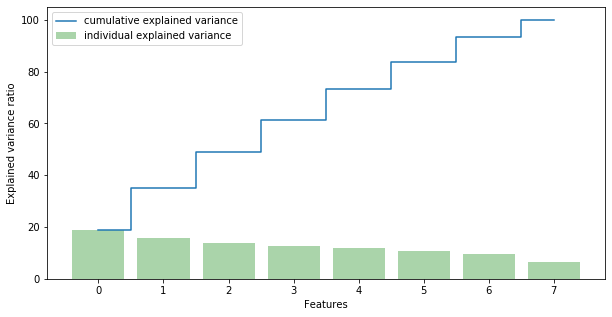

(<Figure size 720x360 with 1 Axes>,
 <BarContainer object of 8 artists>,
 Text(17.200000000000003, 0.5, 'Explained variance ratio'),
 Text(0.5, 17.200000000000003, 'Features'),
 None)

In [534]:
getExplainedVariancePlot(companiesDataframeForTrainingScaled)

## B- Apply Clustering Algorithm

## K-means

Get the optimal number of clusters:

In [535]:
def plotElbowToGetOptimalK(dataframe):
    """
    Input : Dataframe values scaled numeric values
    Output : Plot displaying the distortion for 9 number of clusters 
    """
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(dataframe)
        distortions.append(sum(np.min(cdist(dataframe, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) 
                           / dataframe.shape[0])
        
    return  plt.plot(K, distortions, 'bx-'), plt.xlabel('k'), plt.ylabel('Distortion'), plt.title('The Elbow Method showing the optimal k'), plt.show()   

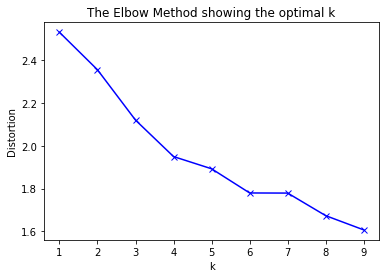

([<matplotlib.lines.Line2D at 0x7fc32db8e750>],
 Text(0.5, 17.200000000000003, 'k'),
 Text(17.200000000000003, 0.5, 'Distortion'),
 Text(0.5, 1, 'The Elbow Method showing the optimal k'),
 None)

In [536]:
plotElbowToGetOptimalK(companiesDataframeForTrainingScaled)

In [537]:
def getNSilhouetteScores(dataframe, rangeNClusters, Algorithm):
    """
    Input : dataframe with scaled numeric values, range of number clusters to try int in a list, algorithm to use in function
    Output : print the silhouette score for each int in the range list
    """
    for numberClusters in rangeNClusters:
        clusterer = Algorithm(n_clusters= numberClusters)
        clusterLabels = clusterer.fit_predict(dataframe)
    
        silhouetteAverage = silhouette_score(dataframe, clusterLabels)
        print("for n_clusters =", numberClusters, "The average silhouette_score is :", silhouetteAverage)
        
    return None

In [538]:
rangeNClusters = [2, 3, 4, 5, 6]
getNSilhouetteScores(companiesDataframeForTrainingScaled, rangeNClusters, KMeans)

for n_clusters = 2 The average silhouette_score is : 0.38264213426881794
for n_clusters = 3 The average silhouette_score is : 0.2181518721575673
for n_clusters = 4 The average silhouette_score is : 0.2508654564241944
for n_clusters = 5 The average silhouette_score is : 0.2589709338490859
for n_clusters = 6 The average silhouette_score is : 0.26697424359062594


According to the Elbow method and to the silhouette score the optimal number of clusters for a k-means is 4.

### Visualization

In [539]:
def plotRepartition(columnToPlot, title, x_axis, y_axis):
    'This function return a repartion plot'
    return plt.hist(list(columnToPlot)), plt.title(title), plt.xlabel(x_axis), plt.ylabel(y_axis), plt.show()

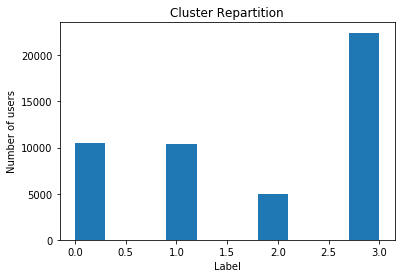

((array([10550.,     0.,     0., 10377.,     0.,     0.,  4995.,     0.,
             0., 22457.]),
  array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
  <a list of 10 Patch objects>),
 Text(0.5, 1, 'Cluster Repartition'),
 Text(0.5, 17.200000000000003, 'Label'),
 Text(17.200000000000003, 0.5, 'Number of users'),
 None)

In [542]:
kmeansModel = KMeans(n_clusters=4).fit(companiesDataframeForTrainingScaled)
kmeansLabels = list(kmeansModel.labels_)

plotRepartition(kmeansLabels, 'Cluster Repartition', 'Label', 'Number of users')

In [543]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(companiesDataframeForTrainingScaled)
reduced=pd.DataFrame(tsne_results,columns=['axis1','axis2'])

In [544]:
def clusterVisualization(labels):
    """
    Input : a list of label defined by the clustering algorithm 
    Output : data visualization of the clusters in 2D
    """
    dataframeLabels=pd.DataFrame(labels,columns=['label'])
    visualization=reduced.join(dataframeLabels,how='inner')
    
    clusterVisualization=visualization.plot.scatter(x='axis1',y='axis2',c='label',colormap='viridis')
    clusterVisualization

    return plt.show()

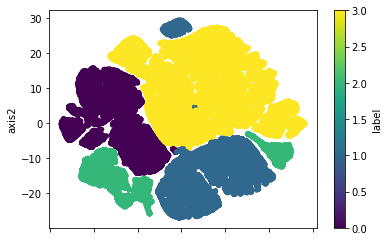

In [545]:
clusterVisualization(kmeansLabels)

## Gaussian Mixture Model

In [546]:
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters)
    cluster_fit = clusterer.fit(companiesDataframeForTrainingScaled)
    labels = cluster_fit.predict(companiesDataframeForTrainingScaled)
    
    silhouette_avg = silhouette_score(companiesDataframeForTrainingScaled, labels)
    print("for n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

for n_clusters = 2 The average silhouette_score is : 0.3476309488197278
for n_clusters = 3 The average silhouette_score is : 0.18294633176895822
for n_clusters = 4 The average silhouette_score is : 0.09922999582808208
for n_clusters = 5 The average silhouette_score is : 0.10622131443164126
for n_clusters = 6 The average silhouette_score is : 0.10143149012054978


### Visualization

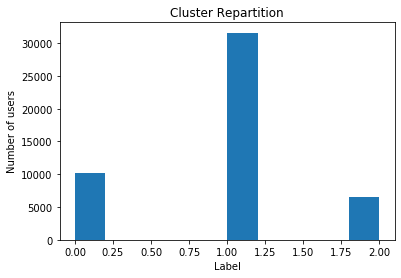

((array([10212.,     0.,     0.,     0.,     0., 31584.,     0.,     0.,
             0.,  6583.]),
  array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
  <a list of 10 Patch objects>),
 Text(0.5, 1, 'Cluster Repartition'),
 Text(0.5, 17.200000000000003, 'Label'),
 Text(17.200000000000003, 0.5, 'Number of users'),
 None)

In [547]:
gmmModel = GaussianMixture(n_components=3).fit(companiesDataframeForTrainingScaled)
gmmLabels = list(gmmModel.predict(companiesDataframeForTrainingScaled))

plotRepartition(gmmLabels, 'Cluster Repartition', 'Label', 'Number of users')

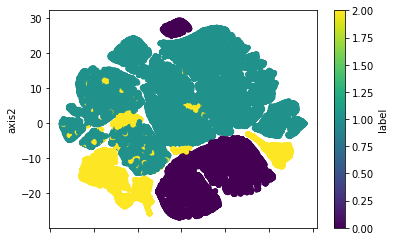

In [548]:
clusterVisualization(gmmLabels)

## DBSCAN 

In [549]:
def plotEpsilonDistance(dataframe, n_neighbors):
    """
    Input : dataframe with scaled numeric values and number of neighbors to consider in int format
    Output : plot of distance between the nearest neighbors
    """
    nNeighbors = NearestNeighbors(n_neighbors)
    nbrs = nNeighbors.fit(dataframe)
    
    distances, indices = nbrs.kneighbors(dataframe)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    return plt.plot(distances), plt.show()

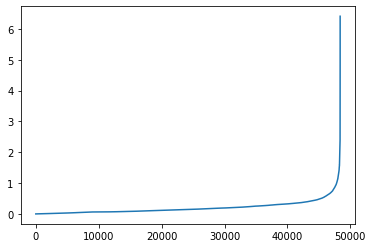

([<matplotlib.lines.Line2D at 0x7fc2fc5ef990>], None)

In [550]:
plotEpsilonDistance(companiesDataframeForTrainingScaled, 3)

In [551]:
dbscanModel = DBSCAN(eps=1.2, min_samples = 100).fit(companiesDataframeForTrainingScaled)

In [552]:
dbscanLabels = dbscanModel.labels_
nClusters = len(set(dbscanLabels))-(1 if -1 in dbscanLabels else 0)
nNoise = list(dbscanLabels).count(-1)

print('Estimated number of clusters: %d'% nClusters)
print('Estimated number of noise points: %d' % nNoise)
print ("Silhouette Coefficient: %0.3f" % silhouette_score(companiesDataframeForTrainingScaled, labels))

Estimated number of clusters: 5
Estimated number of noise points: 2847
Silhouette Coefficient: 0.101


### Visualization

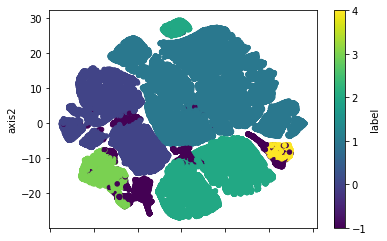

In [553]:
clusterVisualization(dbscanLabels)

## Agglomerative

In [554]:
getNSilhouetteScores(companiesDataframeForTrainingScaled, rangeNClusters, AgglomerativeClustering)

for n_clusters = 2 The average silhouette_score is : 0.3656851876199412
for n_clusters = 3 The average silhouette_score is : 0.16445620310591652
for n_clusters = 4 The average silhouette_score is : 0.21004123393233967
for n_clusters = 5 The average silhouette_score is : 0.22046837272959097
for n_clusters = 6 The average silhouette_score is : 0.22941061093701903


## Visualization

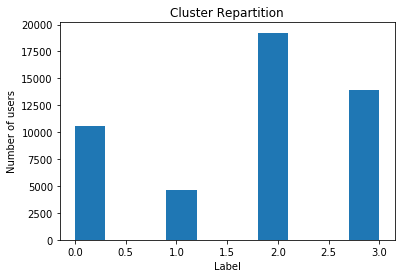

((array([10549.,     0.,     0.,  4623.,     0.,     0., 19245.,     0.,
             0., 13962.]),
  array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
  <a list of 10 Patch objects>),
 Text(0.5, 1, 'Cluster Repartition'),
 Text(0.5, 17.200000000000003, 'Label'),
 Text(17.200000000000003, 0.5, 'Number of users'),
 None)

In [556]:
agglomerativeModel = AgglomerativeClustering(n_clusters=4)
agglomerativeLabels = agglomerativeModel.fit_predict(companiesDataframeForTrainingScaled)

plotRepartition(agglomerativeLabels , 'Cluster Repartition', 'Label', 'Number of users')

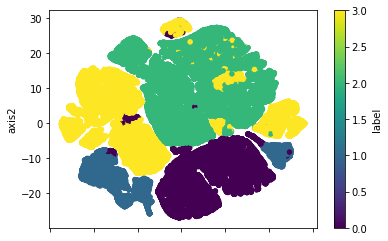

In [557]:
clusterVisualization(agglomerativeLabels)

Categorique

In [429]:
daysOfWeekEncoderDic = {
                        'Monday'   : 1,
                        'Tuesday'  : 2,
                        'Wednesday': 3,
                        'Thursday' : 4,
                        'Friday'   : 5,
                        'Saturday' : 6,
                        'Sunday'   : 7
                       } 

In [430]:
companiesDataframe['dayOfTheWeekEncoder'] = companiesDataframe['dayOfTheWeek'].apply(lambda x : daysOfWeekEncoderDic.get(x))

In [431]:
mainCategoryEncoderDic = {
                        'Publishing'   : 1 ,
                        'Film & Video' : 2 ,
                        'Music'        : 3 ,
                        'Food'         : 4 ,
                        'Design'       : 5 ,
                        'Crafts'       : 6 ,
                        'Games'        : 7 ,
                        'Comics'       : 8 ,
                        'Fashion'      : 9 ,
                        'Theater'      : 10,
                        'Art'          : 11,
                        'Photography'  : 12,
                        'Technology'   : 13,
                        'Dance'        : 14,
                        'Journalism'   : 15,
                       } 

In [432]:
companiesDataframe['mainCategoryEncoded'] = companiesDataframe['main_category'].apply(lambda x: mainCategoryEncoderDic.get(x))

In [434]:
currencyEncoderDic = {
                        'GBP'   : 1 ,
                        'USD'   : 2 ,
                        'CAD'   : 3 ,
                        'AUD'   : 4 ,
                        'NOK'   : 5 ,
                        'EUR'   : 6 ,
                        'MXN'   : 7 ,
                        'SEK'   : 8 ,
                        'NZD'   : 9 ,
                        'CHF'   : 10,
                        'DKK'   : 11,
                        'HKD'   : 12,
                        'SGD'   : 13,
                        'JPY'   : 14
                       } 

In [435]:
companiesDataframe['currencyEncoded'] = companiesDataframe['currency'].apply(lambda x: currencyEncoderDic.get(x))